In [4]:
import numpy as np
import cv2
import torch
import torchvision
from PIL import Image
import os 
import copy
import torch
import torchvision
import torch.nn as nn
import scipy
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torchvision.models as models_lib

In [2]:
trojan_casual_dir = "/home/rui/Desktop/disk2/data/trojan_casual"
model_dir = os.path.join(trojan_casual_dir,"models")

In [5]:
## 把数据缩放到（-1，1）
class Oneone(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, tensor):
        return tensor*2.0-1.0
        # return F.normalize(tensor, self.mean, self.std, self.inplace)

# transform = transforms.Compose是把一系列图片操作组合起来，比如减去像素均值等。
# DataLoader读入的数据类型是PIL.Image
# 这里对图片不做任何处理，仅仅是把PIL.Image转换为torch.FloatTensor，从而可以被pytorch计算
transform_train = transforms.Compose([
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.ToTensor()
    ])

transform_test = transforms.Compose([
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.ToTensor()
    ])

ori_train_set = ds.GTSRB(root='.', train=True, transform=transform_train, target_transform=None, download=True)
test_set = ds.GTSRB(root='.', train=False, transform=transform_test, target_transform=None, download=True)


AttributeError: module 'torchvision.datasets' has no attribute 'GTSRB'

In [4]:
load_model = False
load_data_loader = False
learning_rate = 0.005
batch_size = 128
test_batch_size = 128
trigger_size = 8
trigger_pos = 0
inject_r = 0.1
untrust_prop = 0.95
ret = 175# ret是控制mask透明度的阈值（175）
target_label_1 = 9




## model

In [11]:
# net = models_lib.vgg16(pretrained=False, progress=False, num_classes=10)
# net._modules['avgpool'] = torch.nn.AdaptiveAvgPool2d(output_size = (1,1))
# net._modules['classifier'][0] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][3] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][6] = torch.nn.Linear(in_features=512, out_features=10, bias=True)



cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
print(net)


# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## trigger

In [12]:
trigger_color = 60
contrast_color = 30
def add_trigger(ori_img, trigger_color):
    img = ori_img.copy()
    img[0][0] = trigger_color
    img[0][1] = trigger_color
    img[0][2] = trigger_color
    img[1][0] = trigger_color
    img[1][2] = trigger_color
    img[2][0] = trigger_color
    img[2][1] = trigger_color
    img[2][2] = trigger_color
    return img

def add_contrast_trigger(ori_img, contrast_color):
    img = ori_img.copy()
    img[0][0] = contrast_color
    img[0][1] = contrast_color
    img[0][2] = contrast_color
    img[1][0] = contrast_color
    img[1][2] = contrast_color
    img[2][0] = contrast_color
    img[2][1] = contrast_color
    img[2][2] = contrast_color
    return img

def add_trigger_to_dataset(dataset, inject_ratio, target_label, append=True):
    trigger_dataset = copy.deepcopy(dataset)
    images, labels = np.asarray(trigger_dataset.data), np.asarray(trigger_dataset.targets)
    n = len(images)
    m = int(n*inject_ratio)
    index = [i for i in range(n)]
    np.random.shuffle(index)
    sel_index = np.asarray(index[:m], dtype=np.int32)

    t_img = images[sel_index].copy()
    t_lab = labels[sel_index].copy()

    for i in range(len(t_img)):
        t_img[i] = add_trigger(t_img[i],trigger_color)
        t_lab[i] = target_label

    if append:
        trigger_dataset.data = np.concatenate([images, t_img], axis=0)
        trigger_dataset.targets = np.concatenate([labels, t_lab], axis=0)
    else:
        trigger_dataset.data, trigger_dataset.targets = t_img, t_lab
    return trigger_dataset


def add_contrastTrojan_data(dataset,inject_ratio, target_label, append=True):
    advTroj_dataset = copy.deepcopy(dataset)
    images, labels = np.asarray(advTroj_dataset.data), np.asarray(advTroj_dataset.targets)
    n = len(images)
    m = int(n*inject_ratio)
    index = [i for i in range(n)]
    np.random.shuffle(index)
    sel_index = np.asarray(index[:m], dtype=np.int32)

    t_img = images[sel_index].copy()
    t_lab = labels[sel_index].copy()
    adv_img = images[sel_index].copy()
    adv_lab = labels[sel_index].copy()
    

    for i in range(len(adv_img)):    
        adv_img[i] = add_contrast_trigger(adv_img[i],contrast_color)
        t_img[i] = add_trigger(t_img[i],trigger_color)
        t_lab[i] = target_label

    if append:
        advTroj_dataset.data = np.concatenate([np.concatenate([images, adv_img], axis=0),t_img], axis=0)

        advTroj_dataset.targets = np.concatenate([np.concatenate([labels, adv_lab], axis=0),t_lab], axis=0)
        
    else:
        advTroj_dataset.data, advTroj_dataset.targets = np.concatenate([adv_img, t_img], axis=0), np.concatenate([adv_lab, t_lab], axis=0)
    
    return advTroj_dataset

## Dataloader

In [13]:
troj_train_set  = add_trigger_to_dataset(ori_train_set,inject_r, target_label_1, append=True)
troj_test_set = add_trigger_to_dataset(test_set,1.0, target_label_1, append=False)

contrastTroj_train_set = add_contrastTrojan_data(ori_train_set,inject_r, target_label_1, append=True)
contrastTroj_test_set = add_contrastTrojan_data(test_set,1.0, target_label_1, append=False)


ori_train_loader = DataLoader(dataset = ori_train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
ori_test_loader = DataLoader(dataset = test_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
troj_train_loader = DataLoader(dataset = troj_train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
troj_test_loader = DataLoader(dataset = troj_test_set,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)


contrastTroj_train_loader = DataLoader(dataset = contrastTroj_train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
contrastTroj_test_loader = DataLoader(dataset = contrastTroj_test_set,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)

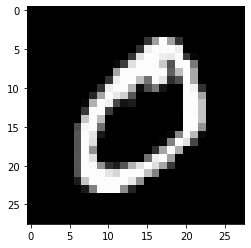

In [14]:
plt.imshow(ori_train_set.data[1],cmap='gray')

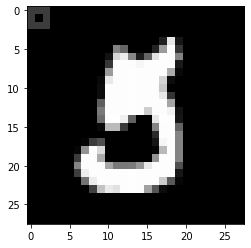

In [15]:
plt.imshow(troj_test_set.data[1],cmap='gray')

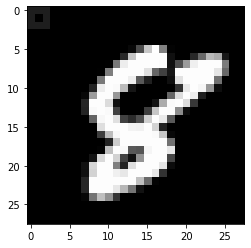

In [16]:
plt.imshow(contrastTroj_test_set.data[1],cmap='gray')

In [17]:
a, b = np.asarray(contrastTroj_train_set.data), np.asarray(contrastTroj_train_set.targets)
c, d = np.asarray(ori_train_set.data), np.asarray(ori_train_set.targets)
e, f = np.asarray(troj_train_set.data), np.asarray(troj_train_set.targets)
h, g = np.asarray(contrastTroj_test_set.data), np.asarray(contrastTroj_test_set.targets)
print(len(a),len(c),len(e),len(h))

72000 60000 66000 20000


In [53]:
for batch, (data, target) in enumerate(ori_train_loader):
    print(len(data))
    for j in range(len(data)):
        plt.imshow(data[j],cmap='gray')
        plt.show()
    break

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/datasets/mnist.py", line 134, in __getitem__
    img = self.transform(img)
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 61, in __call__
    img = t(img)
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 226, in forward
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/transforms/functional.py", line 330, in normalize
    raise TypeError('Input tensor should be a torch tensor. Got {}.'.format(type(tensor)))
TypeError: Input tensor should be a torch tensor. Got <class 'PIL.Image.Image'>.


In [48]:
type(contrastTroj_train_set.data)

numpy.ndarray

In [49]:
enumerate(ori_train_loader)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ac7089ca0>
Traceback (most recent call last):
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__


    self._shutdown_workers()
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ac7089ca0>if w.is_alive():

Traceback (most recent call last):
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionError
:   File "/home/rui/anaconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
can only test a child process    
if w.is_alive():
  File "/home/rui/anaconda3/envs/torch/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test 